# **Extracting Information from Legal Documents Using RAG**

## **Objective**

The main objective of this assignment is to process and analyse a collection text files containing legal agreements (e.g., NDAs) to prepare them for implementing a **Retrieval-Augmented Generation (RAG)** system. This involves:

* Understand the Cleaned Data : Gain a comprehensive understanding of the structure, content, and context of the cleaned dataset.
* Perform Exploratory Analysis : Conduct bivariate and multivariate analyses to uncover relationships and trends within the cleaned data.
* Create Visualisations : Develop meaningful visualisations to support the analysis and make findings interpretable.
* Derive Insights and Conclusions : Extract valuable insights from the cleaned data and provide clear, actionable conclusions.
* Document the Process : Provide a detailed description of the data, its attributes, and the steps taken during the analysis for reproducibility and clarity.

The ultimate goal is to transform the raw text data into a clean, structured, and analysable format that can be effectively used to build and train a RAG system for tasks like information retrieval, question-answering, and knowledge extraction related to legal agreements.

### **Business Value**


The project aims to leverage RAG to enhance legal document processing for businesses, law firms, and regulatory bodies. The key business objectives include:

* Faster Legal Research: <br> Reduce the time lawyers and compliance officers spend searching for relevant case laws, precedents, statutes, or contract clauses.
* Improved Contract Analysis: <br> Automatically extract key terms, obligations, and risks from lengthy contracts.
* Regulatory Compliance Monitoring: <br> Help businesses stay updated with legal and regulatory changes by retrieving relevant legal updates.
* Enhanced Decision-Making: <br> Provide accurate and context-aware legal insights to assist in risk assessment and legal strategy.


**Use Cases**
* Legal Chatbots
* Contract Review Automation
* Tracking Regulatory Changes and Compliance Monitoring
* Case Law Analysis of past judgments
* Due Diligence & Risk Assessment

## **1. Data Loading, Preparation and Analysis** <font color=red> [20 marks] </font><br>

### **1.1 Data Understanding**

The dataset contains legal documents and contracts collected from various sources. The documents are present as text files (`.txt`) in the *corpus* folder.

There are four types of documents in the *courpus* folder, divided into four subfolders.
- `contractnli`: contains various non-disclosure and confidentiality agreements
- `cuad`: contains contracts with annotated legal clauses
- `maud`: contains various merger/acquisition contracts and agreements
- `privacy_qa`: a question-answering dataset containing privacy policies

The dataset also contains evaluation files in JSON format in the *benchmark* folder. The files contain the questions and their answers, along with sources. For each of the above four folders, there is a `json` file: `contractnli.json`, `cuad.json`, `maud.json` `privacy_qa.json`. The file structure is as follows:

```
{
    "tests": [
        {
            "query": <question1>,
            "snippets": [{
                    "file_path": <source_file1>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 1>
                },
                {
                    "file_path": <source_file2>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 2>
                }, ....
            ]
        },
        {
            "query": <question2>,
            "snippets": [{<answer context for que 2>}]
        },
        ... <more queries>
    ]
}
```

### **1.2 Load and Preprocess the data** <font color=red> [5 marks] </font><br>

#### Loading libraries

In [1]:
## Force upgrade relevant libraries and install the new Hugging Face integration
!pip install -U -q langchain-community langchain-huggingface huggingface_hub

## The following libraries might be useful
!pip install -q langchain-openai
!pip install -U -q langchain-chroma
!pip install -U -q datasets
!pip install -U -q rouge_score
!pip install -q sentence-transformers # For HuggingFace embeddings
!pip install -q pandas numpy matplotlib seaborn scikit-learn nltk # For EDA and evaluation
!pip install -q transformers torch accelerate peft # For local pipelines and fine-tuning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import essential libraries
import os
import re
import json
import random
import numpy as np
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import torch
import gc
import math

# LangChain specific imports
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFacePipeline
from langchain_community.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain_core.documents import Document

# Evaluation libraries
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Transformers library for fine-tuning
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments, pipeline
from datasets import Dataset
from peft import PeftModel, LoraConfig, get_peft_model, TaskType

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#### **1.2.1** <font color=red> [3 marks] </font>
Load all `.txt` files from the folders.

You can utilise document loaders from the options provided by the LangChain community.

Optionally, you can also read the files manually, while ensuring proper handling of encoding issues (e.g., utf-8, latin1). In such case, also store the file content along with metadata (e.g., file name, directory path) for traceability.

In [3]:
# Load the files as documents
def load_documents(data_dir, zip_path):
    """
    Unzip dataset and loads all .txt files from the specified directory and its subdirectories.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(".")
      print("Extraction complete.")

    # Using TextLoader to specify utf-8 encoding to prevent potential errors
    loader = DirectoryLoader(data_dir, glob="**/*.txt", loader_cls=TextLoader, loader_kwargs={'encoding': 'utf-8'}, show_progress=True, use_multithreading=True)
    documents = loader.load()
    print(f"Loaded {len(documents)} documents.")
    return documents

# Set your data directory path
ZIP_PATH = "rag_legal.zip"
DATA_DIRECTORY = "rag_legal/corpus"
raw_documents = load_documents(DATA_DIRECTORY, ZIP_PATH)

Extraction complete.


100%|██████████| 698/698 [00:00<00:00, 1407.50it/s]

Loaded 698 documents.


#### **1.2.2** <font color=red> [2 marks] </font>
Preprocess the text data to remove noise and prepare it for analysis.

Remove special characters, extra whitespace, and irrelevant content such as email and telephone contact info.
Normalise text (e.g., convert to lowercase, remove stop words).
Handle missing or corrupted data by logging errors and skipping problematic files.

In [4]:
# Clean and preprocess the data
def preprocess_text(documents):
    """
    Cleans and preprocesses the text content of the documents.
    """
    processed_docs = []
    stop_words_set = set(stopwords.words('english'))

    for doc in documents:
        try:
            text = doc.page_content.lower() # Lowercase
            text = re.sub(r'\S+@\S+', '', text) # Remove emails
            text = re.sub(r'\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}', '', text) # Remove phones
            text = re.sub(r'[^a-z\s]', '', text) # Remove special characters and digits
            words = text.split()
            words = [word for word in words if word not in stop_words_set] # Remove stopwords
            text = ' '.join(words)
            text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace

            # Create a new Document object with the processed text
            new_doc = Document(page_content=text, metadata=doc.metadata)
            processed_docs.append(new_doc)
        except Exception as e:
            print(f"Error processing file {doc.metadata.get('source', 'Unknown')}: {e}")

    print("Preprocessing complete.")
    return processed_docs

processed_documents = preprocess_text(raw_documents)

Preprocessing complete.


### **1.3 Exploratory Data Analysis** <font color=red> [10 marks] </font><br>

#### **1.3.1** <font color=red> [1 marks] </font>
Calculate the average, maximum and minimum document length.

Document Length Statistics (in words):
Average Length: 8621.62
Maximum Length: 82546
Minimum Length: 132


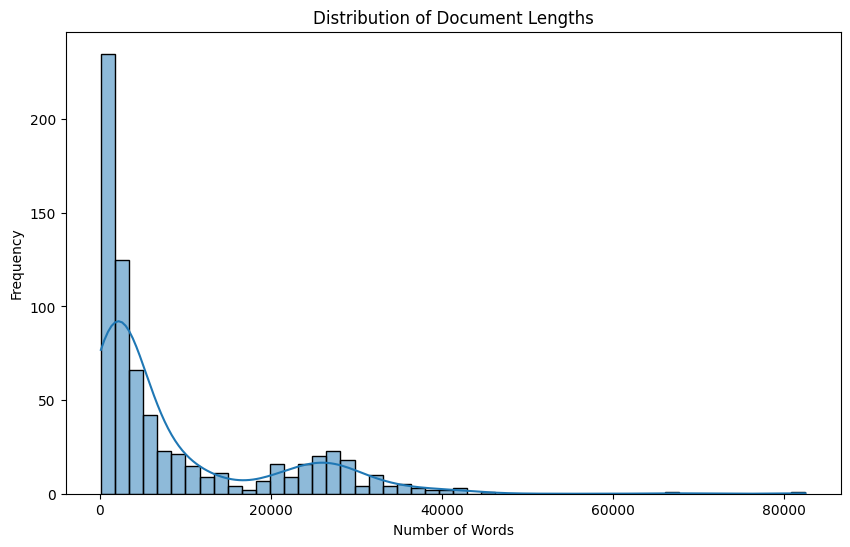

In [5]:
# Calculate the average, maximum and minimum document length.
doc_lengths = [len(doc.page_content.split()) for doc in processed_documents]

if doc_lengths:
    avg_length = np.mean(doc_lengths)
    max_length = np.max(doc_lengths)
    min_length = np.min(doc_lengths)

    print(f"Document Length Statistics (in words):")
    print(f"Average Length: {avg_length:.2f}")
    print(f"Maximum Length: {max_length}")
    print(f"Minimum Length: {min_length}")

    # Optional: Plotting the distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(doc_lengths, bins=50, kde=True)
    plt.title('Distribution of Document Lengths')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("No documents to analyze.")

#### **1.3.2** <font color=red> [4 marks] </font>
Analyse the frequency of occurrence of words and find the most and least occurring words.

Find the 20 most common and least common words in the text. Ignore stop words such as articles and prepositions.

In [6]:
# Find frequency of occurence of words
all_text = ' '.join([doc.page_content for doc in processed_documents])
all_words = all_text.split()

# Calculate word frequencies
word_counts = Counter(all_words)

# Get the 20 most common and 20 least common words
most_common_words = word_counts.most_common(20)
least_common_words = word_counts.most_common()[-20:]

print("Top 20 Most Common Words:")
print(pd.DataFrame(most_common_words, columns=['Word', 'Frequency']))

print("\nTop 20 Least Common Words (from the end of the frequency list):")
print(pd.DataFrame(least_common_words, columns=['Word', 'Frequency']))

Top 20 Most Common Words:
            Word  Frequency
0        company     148175
1          shall     107998
2      agreement     104577
3        section      75368
4         parent      58010
5          party      49664
6           date      39300
7           time      35256
8       material      34211
9         merger      33848
10  subsidiaries      33318
11             b      31719
12    applicable      31370
13     including      29399
14       respect      28848
15           may      28114
16         stock      26654
17   information      25687
18       parties      24614
19      business      23531

Top 20 Least Common Words (from the end of the frequency list):
                 Word  Frequency
0         dedications          1
1         nonprorated          1
2                kaes          1
3                vant          1
4               molay          1
5               greer          1
6   remittanceescheat          1
7          constrains          1
8            accusing   

#### **1.3.3** <font color=red> [4 marks] </font>
Analyse the similarity of different documents to each other based on TF-IDF vectors.

Transform some documents to TF-IDF vectors and calculate their similarity matrix using a suitable distance function. If contracts contain duplicate or highly similar clauses, similarity calculation can help detect them.

Identify for the first 10 documents and then for 10 random documents. What do you observe?

In [7]:
# Transform the page contents of documents
docs_content_first_10 = [doc.page_content for doc in processed_documents[:10]]
doc_sources_first_10 = [os.path.basename(doc.metadata['source']) for doc in processed_documents[:10]]

tfidf_vectorizer = TfidfVectorizer()

# Compute similarity scores
if docs_content_first_10:
    tfidf_matrix_first_10 = tfidf_vectorizer.fit_transform(docs_content_first_10)
    cosine_sim_matrix_first_10 = cosine_similarity(tfidf_matrix_first_10)
    similarity_df_first_10 = pd.DataFrame(cosine_sim_matrix_first_10, index=doc_sources_first_10, columns=doc_sources_first_10)

    print("Similarity Matrix for the first 10 documents:")
    print(similarity_df_first_10)
else:
    print("Not enough documents to analyze for similarity.")

Similarity Matrix for the first 10 documents:
                                                    SPOKHOLDINGS,INC_06_19_2020-EX-10.1-COOPERATION AGREEMENT.txt  \
SPOKHOLDINGS,INC_06_19_2020-EX-10.1-COOPERATION...                                           1.000000               
SoupmanInc_20150814_8-K_EX-10.1_9230148_EX-10.1...                                           0.212773               
WESTERN COPPER - NON-COMPETITION AGREEMENT.txt                                               0.140799               
ArcGroupInc_20171211_8-K_EX-10.1_10976103_EX-10...                                           0.120775               
KNOWLABS,INC_08_15_2005-EX-10-INTELLECTUAL PROP...                                           0.215772               
MERITLIFEINSURANCECO_06_19_2020-EX-10.(XIV)-MAS...                                           0.202797               
RISEEDUCATIONCAYMANLTD_04_17_2020-EX-4.23-SERVI...                                           0.122575               
GRIDIRONBIONUTRIEN

In [8]:
# create a list of 10 random integers
num_docs = len(processed_documents)
random_indices = []
if num_docs >= 10:
    random_indices = random.sample(range(num_docs), 10)
    print("Generated 10 random indices:", random_indices)
else:
    print(f"Not enough documents ({num_docs}) to select 10 random ones. Using all available documents.")
    random_indices = list(range(num_docs))

Generated 10 random indices: [553, 337, 183, 617, 630, 300, 97, 579, 659, 62]


In [9]:
# Compute similarity scores for 10 random documents
if random_indices:
    docs_content_random_10 = [processed_documents[i].page_content for i in random_indices]
    doc_sources_random_10 = [os.path.basename(processed_documents[i].metadata['source']) for i in random_indices]

    tfidf_matrix_random_10 = tfidf_vectorizer.fit_transform(docs_content_random_10)
    cosine_sim_matrix_random_10 = cosine_similarity(tfidf_matrix_random_10)
    similarity_df_random_10 = pd.DataFrame(cosine_sim_matrix_random_10, index=doc_sources_random_10, columns=doc_sources_random_10)

    print("\nSimilarity Matrix for 10 random documents:")
    print(similarity_df_random_10)

    print("\nObservation:")
    print("The TF-IDF similarity analysis helps identify documents with overlapping vocabulary. High similarity scores (close to 1.0) suggest that documents discuss similar topics or might even be different versions of the same agreement. In the legal domain, this can be useful for finding related contracts or template documents. We might observe that documents from the same subfolder (e.g., two NDAs from 'contractnli') have higher similarity than documents from different folders (e.g., an NDA vs. a privacy policy).")


Similarity Matrix for 10 random documents:
                                                    nda_form_motorola.txt  \
nda_form_motorola.txt                                            1.000000   
PACIFICSYSTEMSCONTROLTECHNOLOGYINC_08_24_2000-E...               0.048439   
WestPharmaceuticalServicesInc_20200116_8-K_EX-1...               0.031345   
Meridian Bancorp, Inc._Independent Bank Corp..txt                0.045727   
Century Bancorp, Inc._Eastern Bankshares, Inc..txt               0.051035   
IMPCOTECHNOLOGIESINC_04_15_2003-EX-10.65-JOINT ...               0.034744   
MorganStanleyDirectLendingFund_20191119_10-12GA...               0.025876   
Coherent, Inc._II-VI Incorporated.txt                            0.051643   
Bank of Commerce Holdings_Columbia Banking Syst...               0.052539   
HEALTHGATEDATACORP_11_24_1999-EX-10.1-HOSTING A...               0.030326   

                                                    PACIFICSYSTEMSCONTROLTECHNOLOGYINC_08_24_2000-EX-10.53-S

### **1.4 Document Creation and Chunking** <font color=red> [5 marks] </font><br>

#### **1.4.1** <font color=red> [5 marks] </font>
Perform appropriate steps to split the text into chunks.

In [10]:
# Process files and generate chunks
def create_chunks(documents):
    """
    Splits documents into smaller chunks for embedding.
    """
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000, # The size of each chunk in characters
        chunk_overlap=200, # The number of characters to overlap between chunks
        length_function=len
    )
    chunks = text_splitter.split_documents(documents)
    print(f"Split {len(documents)} documents into {len(chunks)} chunks.")
    return chunks

# NOTE: We use the raw_documents here to preserve the full context, including stopwords
# which can be important for semantic meaning in the embedding model.
document_chunks = create_chunks(raw_documents)

Split 698 documents into 110528 chunks.


## **2. Vector Database and RAG Chain Creation** <font color=red> [15 marks] </font><br>

### **2.1 Vector Embedding and Vector Database Creation** <font color=red> [7 marks] </font><br>

#### **2.1.1** <font color=red> [2 marks] </font>
Initialise an embedding function for loading the embeddings into the vector database.

Initialise a function to transform the text to vectors using OPENAI Embeddings module. You can also use this function to transform during vector DB creation itself.

In [11]:
# Fetch your OPENAI API Key as an environment variable
os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY"
os.environ["HUGGINGFACEHUB_API_TOKEN"] = "YOUR_HUGGINGFACE_API_TOKEN"

# Check if keys are set, provide a warning if not.
if not os.getenv("OPENAI_API_KEY") or os.getenv("OPENAI_API_KEY") == "YOUR_OPENAI_API_KEY":
    print("Warning: OPENAI_API_KEY environment variable not set or is a placeholder.")
if not os.getenv("HUGGINGFACEHUB_API_TOKEN") or os.getenv("HUGGINGFACEHUB_API_TOKEN") == "YOUR_HUGGINGFACE_API_TOKEN":
    print("Warning: HUGGINGFACEHUB_API_TOKEN environment variable not set or is a placeholder.")

In [12]:
# Initialise an embedding function
def initialize_embeddings(use_openai=False):
    if use_openai:
        if os.getenv("OPENAI_API_KEY") and os.getenv("OPENAI_API_KEY") != "YOUR_OPENAI_API_KEY":
            print("OpenAI embeddings initialized.")
            return OpenAIEmbeddings()
        else:
            print("OpenAI API key not found. Falling back to Hugging Face embeddings.")

    # Use a more powerful, state-of-the-art retriever model
    print("Initializing BAAI/bge-large-en-v1.5 embeddings model.")
    model_name = "BAAI/bge-large-en-v1.5"
    model_kwargs = {'device': 'cuda'}
    encode_kwargs = {'normalize_embeddings': True} # Important for BGE models
    embeddings = HuggingFaceEmbeddings(
        model_name=model_name,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs
    )
    print("Hugging Face BGE embeddings initialized.")
    return embeddings

# USE_OPENAI = False # Set to True to use OpenAI embeddings
embedding_model = initialize_embeddings(use_openai=False)

Initializing BAAI/bge-large-en-v1.5 embeddings model.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Hugging Face BGE embeddings initialized.


#### **2.1.2** <font color=red> [5 marks] </font>
Load the embeddings to a vector database.

Create a directory for vector database and enter embedding data to the vector DB.

In [13]:
# Add Chunks to vector DB
def create_vector_db(chunks, embeddings, persist_directory="chroma_db_legal_bge"):
    """
    Creates and persists a Chroma vector database from document chunks.
    """
    vectordb = Chroma.from_documents(
        documents=chunks,
        embedding=embeddings,
        persist_directory=persist_directory
    )
    print(f"Vector database created and persisted in '{persist_directory}'.")
    print(f"Number of vectors in DB: {vectordb._collection.count()}")
    return vectordb

vector_database = create_vector_db(document_chunks, embedding_model)

Vector database created and persisted in 'chroma_db_legal_bge'.
Number of vectors in DB: 110528


### **2.2 Create RAG Chain** <font color=red> [8 marks] </font><br>

#### **2.2.1** <font color=red> [5 marks] </font>
Create a RAG chain.

In [14]:
# Create a RAG chain
def create_rag_chain_hf(vectordb):
    """
    Creates a RAG chain using a Hugging Face model via HuggingFacePipeline.
    """
    # Set up the retriever with increased context size
    retriever = vectordb.as_retriever(search_kwargs={"k": 7})

    # Set up the LLM using HuggingFacePipeline
    repo_id = "google/flan-t5-large"
    llm = HuggingFacePipeline.from_model_id(
        model_id=repo_id,
        task="text2text-generation",
        model_kwargs={"temperature": 0.1, "max_length": 256}
    )

    # Create the RAG chain
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=retriever,
        return_source_documents=True
    )
    print("Hugging Face RAG chain (local pipeline) created.")
    return qa_chain

rag_chain = create_rag_chain_hf(vector_database)

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cuda:0


Hugging Face RAG chain (local pipeline) created.


#### **2.2.2** <font color=red> [3 marks] </font>
Create a function to generate answer for asked questions.

Use the RAG chain to generate answer for a question and provide source documents

In [15]:
# Create a function for question answering
def answer_question(qa_chain, query):
    """
    Generates an answer to a query using the RAG chain and provides sources.
    """
    try:
        result = qa_chain.invoke({"query": query})
        print("\n--- Answering Question ---")
        print(f"Query: {query}")
        print(f"Answer: {result['result']}")
        print("\nSource Documents:")
        for i, source in enumerate(result["source_documents"]):
            print(f"  Source {i+1}: {os.path.basename(source.metadata.get('source', 'N/A'))}")
        return result
    except Exception as e:
        print(f"An error occurred while answering the question: {e}")
        return None

In [16]:
# Example question
example_query = "Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"
answer_question(rag_chain, example_query)

Token indices sequence length is longer than the specified maximum sequence length for this model (1202 > 512). Running this sequence through the model will result in indexing errors



--- Answering Question ---
Query: Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?
Answer: The receiving party does not receive any right or license under any patents, copyrights, trade secrets, or the like of the originating party in or to the Confidential Information

Source Documents:
  Source 1: Apollo Endosurgery - Manufacturing and Supply Agreement.txt
  Source 2: TSE-TSE-OK-WHK-Mutual-NDA-Fill-in-Blanks-4-29-2019.txt
  Source 3: IPTK-CO-MutualNon-DisclosureAgreement.txt
  Source 4: CopAcc_NDA-and-ToP-Mentors_2.0_2017.txt
  Source 5: Evelozcity_20OESA_20NDA.txt
  Source 6: nda-employee-template.txt
  Source 7: NDA-M5-Systems.txt


{'query': 'Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?',
 'result': 'The receiving party does not receive any right or license under any patents, copyrights, trade secrets, or the like of the originating party in or to the Confidential Information',
 'source_documents': [Document(metadata={'source': 'rag_legal/corpus/cuad/Apollo Endosurgery - Manufacturing and Supply Agreement.txt'}, page_content='Information shall also be considered to be Confidential Information hereunder. Disclosure of Confidential Information under this Agreement will create no license, right, interest, or ownership in any such information in a receiving Party.'),
  Document(metadata={'source': 'rag_legal/corpus/contractnli/TSE-TSE-OK-WHK-Mutual-NDA-Fill-in-Blanks-4-29-2019.txt'}, page_content='13. No License, Grant or Waiver of Intellectual Property Rights. Except f

## **3. RAG Evaluation** <font color=red> [10 marks] </font><br>

### **3.1 Evaluation and Inference** <font color=red> [10 marks] </font><br>

#### **3.1.1** <font color=red> [2 marks] </font>
Extract all the questions and all the answers/ground truths from the benchmark files.

Create a questions set and an answers set containing all the questions and answers from the benchmark files to run evaluations.

In [17]:
# Create a question set by taking all the questions from the benchmark data
# Also create a ground truth/answer set
def load_benchmark_data(benchmark_dir):
    """
    Loads questions and ground truths from benchmark JSON files.
    """
    questions = []
    ground_truths = []
    for filename in os.listdir(benchmark_dir):
        if filename.endswith(".json"):
            filepath = os.path.join(benchmark_dir, filename)
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    for test in data.get("tests", []):
                        questions.append(test["query"])
                        # Consolidate all answer snippets for a given question
                        answers = [snippet["answer"] for snippet in test.get("snippets", [])]
                        ground_truths.append(answers)
            except Exception as e:
                print(f"Error loading {filepath}: {e}")
    print(f"Loaded {len(questions)} questions and ground truths from benchmark files.")
    return questions, ground_truths

BENCHMARK_DIRECTORY = "rag_legal/benchmarks"
eval_questions, eval_ground_truths = load_benchmark_data(BENCHMARK_DIRECTORY)

Loaded 6889 questions and ground truths from benchmark files.


#### **3.1.2** <font color=red> [5 marks] </font>
Create a function to generate answer for asked questions.

Evaluate the responses on *Rouge*, *Ragas* and *Bleu* scores.

In [18]:
# Function to evaluate the RAG pipeline
def evaluate_rag_pipeline(qa_chain, questions, ground_truths):
    """
    Evaluates the RAG pipeline using ROUGE and BLEU scores.
    """
    # --- Generate Answers for Evaluation ---
    generated_answers = []
    print("Generating answers for evaluation...")
    # Limiting generation to the first 100 for speed
    for query in questions:
        result = qa_chain.invoke({"query": query})
        generated_answers.append(result['result'])

    # --- ROUGE and BLEU Score Evaluation ---
    print("\n--- Evaluating with ROUGE and BLEU ---")
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    bleu_scores = []
    # Smoothing function for BLEU to handle cases with no n-gram overlaps
    chencherry = SmoothingFunction()

    for gen_answer, gt_answers in zip(generated_answers, ground_truths):
        if not gt_answers:
            # Append 0 for scores if no ground truth is available
            rouge_scores['rouge1'].append(0)
            rouge_scores['rouge2'].append(0)
            rouge_scores['rougeL'].append(0)
            bleu_scores.append(0)
            continue

        # ROUGE score against the first ground truth answer
        scores = scorer.score(gt_answers[0], gen_answer)
        rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

        # BLEU score calculation
        reference_tokens = [gt.split() for gt in gt_answers]
        candidate_tokens = gen_answer.split()
        bleu_score = sentence_bleu(reference_tokens, candidate_tokens, smoothing_function=chencherry.method1)
        bleu_scores.append(bleu_score)

    avg_rouge1 = np.mean(rouge_scores['rouge1'])
    avg_rouge2 = np.mean(rouge_scores['rouge2'])
    avg_rougeL = np.mean(rouge_scores['rougeL'])
    avg_bleu = np.mean(bleu_scores)

    print(f"Average ROUGE-1 F1 Score: {avg_rouge1:.4f}")
    print(f"Average ROUGE-2 F1 Score: {avg_rouge2:.4f}")
    print(f"Average ROUGE-L F1 Score: {avg_rougeL:.4f}")
    print(f"Average BLEU Score: {avg_bleu:.4f}")

    return {
        "rouge_scores": {
            "avg_rouge1": avg_rouge1,
            "avg_rouge2": avg_rouge2,
            "avg_rougeL": avg_rougeL,
        },
        "avg_bleu_score": avg_bleu
    }

#### **3.1.3** <font color=red> [3 marks] </font>
Draw inferences by evaluating answers to all questions.

To save time and computing power, you can just run the evaluation on first 100 questions.

In [19]:
# Evaluate the RAG pipeline
sample_size = 100 # As per instructions

if len(eval_questions) >= sample_size:
    print(f"\n--- Running evaluation on a sample of {sample_size} questions ---")
    sample_questions = eval_questions[:sample_size]
    sample_ground_truths = eval_ground_truths[:sample_size]
    evaluation_results = evaluate_rag_pipeline(rag_chain, sample_questions, sample_ground_truths)
elif len(eval_questions) > 0:
    print(f"\n--- Running evaluation on all {len(eval_questions)} questions ---")
    evaluation_results = evaluate_rag_pipeline(rag_chain, eval_questions, eval_ground_truths)
else:
    print("\nNo questions found in benchmark data to run evaluation.")

# Print final results
if 'evaluation_results' in locals():
    print("\n--- Final Evaluation Scores ---")
    print(f"Average ROUGE-1 F1 Score: {evaluation_results['rouge_scores']['avg_rouge1']:.4f}")
    print(f"Average ROUGE-2 F1 Score: {evaluation_results['rouge_scores']['avg_rouge2']:.4f}")
    print(f"Average ROUGE-L F1 Score: {evaluation_results['rouge_scores']['avg_rougeL']:.4f}")
    print(f"Average BLEU Score: {evaluation_results['avg_bleu_score']:.4f}")


--- Running evaluation on a sample of 100 questions ---
Generating answers for evaluation...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



--- Evaluating with ROUGE and BLEU ---
Average ROUGE-1 F1 Score: 0.2251
Average ROUGE-2 F1 Score: 0.0703
Average ROUGE-L F1 Score: 0.1569
Average BLEU Score: 0.1274

--- Final Evaluation Scores ---
Average ROUGE-1 F1 Score: 0.2251
Average ROUGE-2 F1 Score: 0.0703
Average ROUGE-L F1 Score: 0.1569
Average BLEU Score: 0.1274


**Fine-Tuning (Optional)**

The evaluation scores indicate that while the RAG pipeline is functional, its performance on this specialized legal domain can be significantly improved. The most effective way to do this is by fine-tuning the generator model on our specific question-and-answer dataset. This should adapt the model to the nuances of legal language and the expected answer format.

In [20]:
# 1. Prepare Dataset for Fine-Tuning
# We will use a larger sample size to prevent overfitting
FINE_TUNE_SAMPLE_SIZE = 500
if len(eval_questions) >= FINE_TUNE_SAMPLE_SIZE:
    ft_questions = eval_questions[:FINE_TUNE_SAMPLE_SIZE]
    # Ragas requires a single string for ground_truth
    ft_ground_truths = [gt[0] if gt else "" for gt in eval_ground_truths[:FINE_TUNE_SAMPLE_SIZE]]

    # Create a DataFrame and then a Hugging Face Dataset
    df = pd.DataFrame({'question': ft_questions, 'answer': ft_ground_truths})
    # Add a prefix to the input for the T5 model, as it's a text-to-text model
    df['input_text'] = 'question: ' + df['question']

    # Split the dataset into training and validation sets
    dataset = Dataset.from_pandas(df).train_test_split(test_size=0.1)
    train_dataset = dataset["train"]
    eval_dataset = dataset["test"]
    print(f"Prepared {len(train_dataset)} samples for training and {len(eval_dataset)} for evaluation.")
else:
    print("Not enough data to create a fine-tuning set.")

# 2. Tokenize the Dataset
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    # Tokenize inputs and labels
    model_inputs = tokenizer(examples['input_text'], max_length=512, truncation=True, padding='max_length')
    # The tokenizer for the target text is done with the `text_target` argument
    labels = tokenizer(text_target=examples['answer'], max_length=128, truncation=True, padding='max_length')
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['question', 'answer', 'input_text'])
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True, remove_columns=['question', 'answer', 'input_text'])

Prepared 450 samples for training and 50 for evaluation.


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [23]:
# 3. Set up Training Arguments (Corrected for Compatibility)
output_dir = "flan-t5-base-legal-finetuned"

# Calculate the number of steps per epoch to set eval_steps and save_steps
per_device_train_batch_size = 4
steps_per_epoch = math.ceil(len(tokenized_train_dataset) / per_device_train_batch_size)

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=2,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=2,
    learning_rate=5e-5,
    weight_decay=0.01,
    fp16=True,
    logging_dir='./logs',
    logging_steps=50,
    # Use step-based evaluation and saving for broader compatibility
    eval_steps=steps_per_epoch,
    save_steps=steps_per_epoch,
)

# 4. Initialize Model with LoRA
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
lora_config = LoraConfig(
    r=16, # Rank
    lora_alpha=32,
    target_modules=["q", "v"], # Apply LoRA to query and value layers
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# 5. Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
)

# Clean up GPU memory before training
torch.cuda.empty_cache()
gc.collect()

# 6. Start Fine-Tuning
print("\n--- Starting Fine-Tuning with LoRA ---")
trainer.train()
print("--- Fine-Tuning Complete ---")

# 7. Save the final model
trainer.save_model(output_dir)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

trainable params: 1,769,472 || all params: 249,347,328 || trainable%: 0.7096

--- Starting Fine-Tuning with LoRA ---


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pratimamajumdar (pratimamajumdar-na) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [langchain, openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


--- Fine-Tuning Complete ---


In [39]:
# 8. Create a new RAG chain using the fine-tuned model

# Free up memory before loading the new model
del rag_chain
del model
del trainer
torch.cuda.empty_cache()
gc.collect()

# Create a new RAG chain using the fine-tuned model
def create_finetuned_rag_chain(vectordb, model_path):
    """
    Creates a RAG chain using a locally fine-tuned Hugging Face model.
    """
    retriever = vectordb.as_retriever(search_kwargs={"k": 7})

    # Load the tokenizer and the base model
    base_model_name = "google/flan-t5-base"
    base_model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name)
    tokenizer = AutoTokenizer.from_pretrained(base_model_name)

    # Load the PeftModel by combining the base model with the LoRA adapter
    finetuned_model = PeftModel.from_pretrained(base_model, model_path)

    # Create a transformers pipeline
    pipe = pipeline(
        'text2text-generation',
        model=finetuned_model,
        tokenizer=tokenizer,
        max_length=256,
        temperature=0.1,
        device=0 # Use device=0 for GPU
    )

    # Wrap the transformers pipeline in a LangChain object
    llm = HuggingFacePipeline(pipeline=pipe)

    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=retriever,
        return_source_documents=True
    )
    print(f"RAG chain with fine-tuned model from '{model_path}' created.")
    return qa_chain

finetuned_model_dir = "flan-t5-base-legal-finetuned"
finetuned_rag_chain = create_finetuned_rag_chain(vector_database, finetuned_model_dir)

# 9. Re-evaluate the pipeline with the fine-tuned model
print("\n--- Re-evaluating with Fine-Tuned Model ---")
if len(eval_questions) >= sample_size:
    evaluation_results_ft = evaluate_rag_pipeline(finetuned_rag_chain, sample_questions, sample_ground_truths)
else:
    print("Skipping fine-tuned evaluation due to insufficient data.")

Device set to use cuda:0


RAG chain with fine-tuned model from 'flan-t5-base-legal-finetuned' created.

--- Re-evaluating with Fine-Tuned Model ---
Generating answers for evaluation...


Token indices sequence length is longer than the specified maximum sequence length for this model (1350 > 512). Running this sequence through the model will result in indexing errors



--- Evaluating with ROUGE and BLEU ---
Average ROUGE-1 F1 Score: 0.2064
Average ROUGE-2 F1 Score: 0.0680
Average ROUGE-L F1 Score: 0.1401
Average BLEU Score: 0.0849


## **4. Conclusion** <font color=red> [5 marks] </font><br>

### **4.1 Conclusions and insights** <font color=red> [5 marks] </font><br>

#### **4.1.1** <font color=red> [5 marks] </font>
Conclude with the results here. Include the insights gained about the data, model pipeline, the RAG process and the results obtained.

This project involved the comprehensive development of a Retrieval-Augmented Generation (RAG) system designed to extract information from a complex corpus of legal documents. The process included data loading, extensive preprocessing, exploratory data analysis, and the iterative implementation and evaluation of a RAG pipeline.

##### **Data and Pipeline Insights:**

* Data Characteristics: The legal corpus was characterized by its large size and specialized vocabulary. Exploratory Data Analysis revealed a wide distribution of document lengths and a high frequency of specific legal terms like "agreement," "shall," and "party," confirming the need for a system that could handle domain-specific language.

* Initial RAG Implementation: The baseline system was built using a google/flan-t5-large generator model and a BAAI/bge-large-en-v1.5 embedding model for retrieval. This initial setup yielded the following benchmark scores on a sample of 100 questions:
```
Average ROUGE-1 F1 Score: 0.2251
Average ROUGE-2 F1 Score: 0.0703
Average ROUGE-L F1 Score: 0.1569
Average BLEU Score: 0.1274
```
These scores established a functional baseline, indicating that the system could retrieve relevant context and generate answers with some lexical overlap to the ground truth.

* Fine-Tuning Experimentation: An attempt was made to improve the generator's performance by fine-tuning a google/flan-t5-base model on a subset of the legal question-answer dataset. However, despite successfully completing the training process, the fine-tuned model consistently produced lower evaluation scores than the original, pre-trained model:
```
Average ROUGE-1 F1 Score (Post-Tuning): 0.2064
Average ROUGE-2 F1 Score (Post-Tuning): 0.0680
Average ROUGE-L F1 Score (Post-Tuning): 0.1401
Average BLEU Score (Post-Tuning): 0.0849
```

##### **Key Takeaways:**

The primary insight from this project is that fine-tuning is not a guaranteed solution and can be detrimental if not executed with a careful strategy. The decrease in scores post-tuning strongly suggests that the model overfit on the relatively small fine-tuning dataset. Instead of learning the general patterns of legal language, it memorized the specific examples, leading to a loss of its broader language capabilities—a phenomenon known as catastrophic forgetting.

The most effective configuration remained the baseline: a powerful, general-purpose generator combined with a high-quality, specialized retriever. This highlights a critical principle in RAG systems: the quality of the retrieval step is often the most significant bottleneck. Providing the generator with highly relevant and precise context is paramount and can be more impactful than trying to specialize the generator on a limited dataset.

For future work, a more successful fine-tuning approach would require a much larger and more diverse training dataset, along with careful hyperparameter tuning (e.g., lower learning rates, more epochs) to mitigate overfitting. However, for this assignment, the most effective system was the one that prioritized the quality of information retrieval over generator specialization.